# LSTM Implementation - WTI Crude Oil data


**Notebook Summary**


**Granularity**: monthly data

**Source**: FRED

**Time period**: 1986-01-01 / 2022-01-01

**Model**: LSTM

#Importing libraries

In [ ]:
# Standard libraries
import warnings
warnings.filterwarnings("ignore")
import io
import math
import pandas as pd
import numpy as np

# Keras
import keras
from keras.layers import *
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor

# Sklearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving MCOILWTICO.csv to MCOILWTICO.csv


# Load data


In [ ]:
# Import raw data
data = pd.read_csv(io.BytesIO(uploaded['MCOILWTICO.csv']) , index_col = 'DATE', parse_dates = True) 

# Exploratory analysis

In [ ]:
data.head()

,MCOILWTICO
DATE,
1986-01-01,22.93
1986-02-01,15.46
1986-03-01,12.61
1986-04-01,12.84
1986-05-01,15.38


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 1986-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MCOILWTICO  433 non-null    float64
dtypes: float64(1)
memory usage: 6.8 KB


In [ ]:
data.describe()

,MCOILWTICO
count,433.000000
mean,44.790577
std,28.718807
min,11.350000
25%,19.900000
50%,33.510000
75%,63.860000
max,133.880000


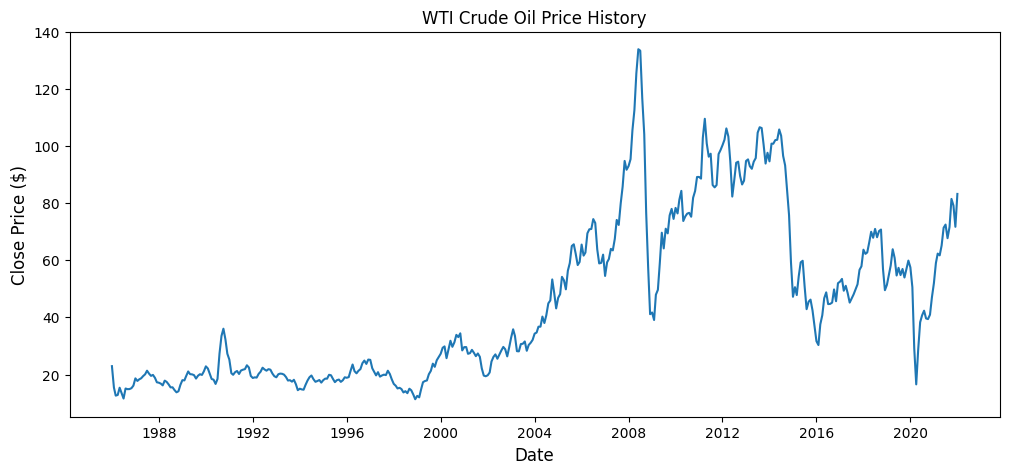

In [ ]:
# Plot the price history
plt.figure(figsize=(12,5))
plt.title('WTI Crude Oil Price History')
plt.plot(data['MCOILWTICO'])
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price ($)', fontsize = 12)
plt.show()

In [ ]:
# Create a new feature
log_returns = np.log(data["MCOILWTICO"]).diff(1) 
data["log_returns"] = log_returns 

In [ ]:
# Refine the dataset
data = data[["log_returns"]]

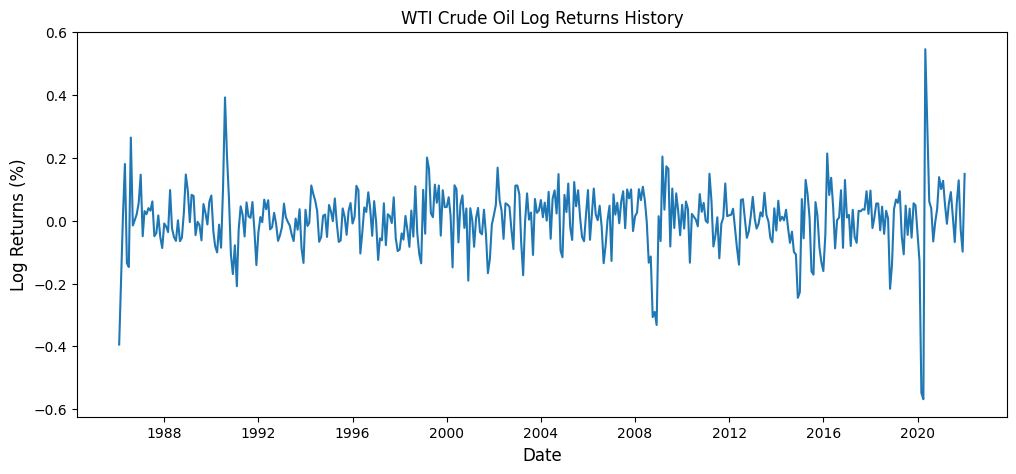

In [ ]:
# Plot the log returns
plt.figure(figsize=(12,5))
plt.title('WTI Crude Oil Log Returns History')
plt.plot(data)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Log Returns (%)', fontsize = 12)
plt.show()

In [ ]:
# Drop the first row containing a NaN value
data = data[1:]
data

,log_returns
DATE,
1986-02-01,-0.394190
1986-03-01,-0.203766
1986-04-01,0.018075
1986-05-01,0.180503
1986-06-01,-0.135577
...,...
2021-09-01,0.056264
2021-10-01,0.128564
2021-11-01,-0.029013


#Data processing

### Train-Test split

In [ ]:
# Train and test split
ratio = 0.8
train_size = int(len(data)* ratio) 
train_data = data[:train_size]
test_data = data[train_size:]

### Building input features

In [ ]:
# Define the look-back and look-forward variables
look_back = 48 
look_forward = 6 

In [ ]:
# Convert an array of values into a dataset matrix

def create_features(data, look_back=48, look_forward=6):
    dataX, dataY = [], []
    np.array(dataY)
    for k in range(len(data)-look_back-1):
        a = data[k:(k + look_back), 0]
        if len(data[k + look_back: k + look_back + look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(data[k + look_back: k + look_back + look_forward, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Generate train X and train Y data
trainX, trainY = create_features(train_data.values, look_back, look_forward)

In [ ]:
# Generate test X and test Y data
testX, testY = create_features(test_data.values, look_back, look_forward)

###Reshape to 3D data

In [ ]:
# Reshape input to be (samples, time steps, features)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(292, 48, 1)
(292, 6)
(34, 48, 1)
(34, 6)


#LSTM Model Builder

In [ ]:
# Create a function that build an LSTM 

def create_lstm(input_shape = (look_back, 1), lstm_units=128, dense_units=6, drop_rate = 0.1):
    # Initialising the LSTM
    model = Sequential()

    # Adding the LSTM layer and some dropout regularization
    model.add(LSTM(units=lstm_units, input_shape=input_shape, stateful=False))
    model.add(Dropout(rate = drop_rate))

    # Adding a Dense layer
    model.add(Dense(units= lstm_units))
    model.add(Dropout(rate = drop_rate))
    model.add(Dense(units= lstm_units))
    model.add(Dropout(rate = drop_rate))
    model.add(Dense(units= dense_units))

    # Compiling the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
    return model


In [ ]:
# Instantiate an LSTM model to wrap in KerasRegressor
lstm = KerasRegressor(build_fn = create_lstm, verbose=0)

# Block Time Series Split and GridSearch CV

In [ ]:
# Define a Block Time Series Split (no overlapping data)
class BlockTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            end = start + k_fold_size
            mid = int(0.5 * (end - start)) + start
            yield indices[start: mid], indices[mid + margin: end]

In [ ]:
# Define the number of splits and get some metrics
btscv = BlockTimeSeriesSplit(n_splits= 10)

###Define the parameters to tune

In [ ]:
# Define the parameter grid for GridSearch
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 15, 20],
    'drop_rate' : [0.1, 0.15],
    'lstm_units':[64, 128, 256]}

###Run GridSearchCV

In [ ]:
# Create the GridSearchCV object with BlockTimeSeriesSplit
#grid_search = GridSearchCV(estimator = lstm, param_grid = param_grid, cv = btscv, scoring = 'neg_mean_squared_error')

In [ ]:
# Fit the data to the GridSearchCV object
#grid_result = grid_search.fit(trainX, trainY)

In [ ]:
# Access the best parameters and best score
#best_params = grid_result.best_params_
#best_score = grid_result.best_score_
#print("Best parameters:", best_params)
#print("Best score:" , best_score)

# Fit the best model

In [ ]:
# Store the best_params dictionary to avoid re-running GridSearch
best_params = {'batch_size': 32, 'drop_rate': 0.1, 'epochs': 15, 'lstm_units': 64}

In [ ]:
# Use the best parameters to create the LSTM model
model = create_lstm(lstm_units =best_params['lstm_units'], drop_rate = best_params['drop_rate'])

In [ ]:
# Fitting the model
history = model.fit(trainX, trainY, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

Epoch 1/15
10/10 [==============================] - 4s 36ms/step - loss: 0.0069 - accuracy: 0.1610
Epoch 2/15
10/10 [==============================] - 0s 30ms/step - loss: 0.0068 - accuracy: 0.1884
Epoch 3/15
10/10 [==============================] - 0s 21ms/step - loss: 0.0067 - accuracy: 0.1986
Epoch 4/15
10/10 [==============================] - 0s 21ms/step - loss: 0.0066 - accuracy: 0.1986
Epoch 5/15
10/10 [==============================] - 0s 21ms/step - loss: 0.0067 - accuracy: 0.1815
Epoch 6/15
10/10 [==============================] - 0s 23ms/step - loss: 0.0066 - accuracy: 0.1849
Epoch 7/15
10/10 [==============================] - 0s 21ms/step - loss: 0.0066 - accuracy: 0.1952
Epoch 8/15
10/10 [==============================] - 0s 22ms/step - loss: 0.0066 - accuracy: 0.1815
Epoch 9/15
10/10 [==============================] - 0s 21ms/step - loss: 0.0066 - accuracy: 0.1849
Epoch 10/15
10/10 [==============================] - 0s 22ms/step - loss: 0.0067 - accuracy: 0.1884
Epoch 11/

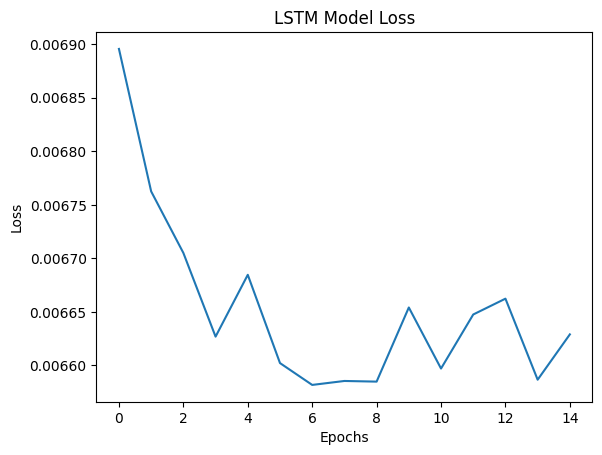

In [ ]:
# Plot the loss over the epochs
plt.plot(history.history['loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Predict the model using test X data
y_pred = model.predict(testX)

2/2 [==============================] - 0s 8ms/step


In [ ]:
# Get a sense of how y_pred looks like
y_pred

array([[ 0.00205271, -0.00592696, -0.0088927 ,  0.00232333,  0.00087099,
         0.00439752],
       [-0.02896225, -0.00449356,  0.00592085,  0.02783963,  0.02997879,
         0.02802352],
       [-0.02159283,  0.0073434 ,  0.01720432,  0.03982434,  0.03786336,
         0.03415324],
       [ 0.01465572,  0.01877595,  0.01629168,  0.03027539,  0.02076012,
         0.02002963],
       [ 0.03435336,  0.02098163,  0.01137723,  0.02022021,  0.00794148,
         0.00974292],
       [ 0.0377918 ,  0.01748798,  0.00616834,  0.01378116,  0.00241598,
         0.00553333],
       [ 0.04049291,  0.01221095, -0.00116988,  0.0047236 , -0.00509419,
        -0.00025665],
       [ 0.01650385,  0.00565593,  0.00077475,  0.01337668,  0.00870601,
         0.01127721],
       [-0.00144912,  0.00561134,  0.00788663,  0.02642819,  0.02430776,
         0.0240701 ],
       [ 0.01714605,  0.01054249,  0.00584161,  0.01923085,  0.01359585,
         0.01525311],
       [ 0.0110273 ,  0.01072714,  0.0085897 ,  0.

In [ ]:
print(y_pred.shape)

(34, 6)


###Compute the MSE and RMSE

In [ ]:
mse = mean_squared_error(testY, y_pred)
print("MSE:", mse)
print('RMSE:', np.sqrt(mse))

MSE: 0.03477761743142763
RMSE: 0.18648757983154704


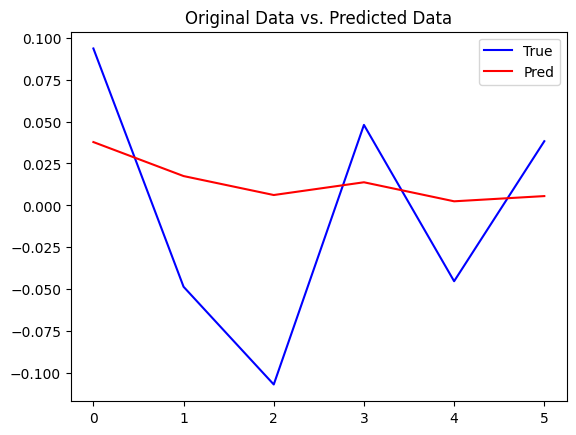

In [ ]:
# Plot one prediction against test data
plt.plot(testY[5], color = "b", label = "True")
plt.plot(y_pred[5], color = "r", label = "Pred")
plt.title('Original Data vs. Predicted Data')
plt.legend()
plt.show()

# Get a single prediction

In [ ]:
# Get a single observation
single = testX[20].reshape(1, testX[20].shape[0], testX[20].shape[1])
single.shape

(1, 48, 1)

In [ ]:
# Make a prediction
single_pred = model.predict(single)

1/1 [==============================] - 0s 28ms/step


In [ ]:
single_pred

array([[ 0.1342338 ,  0.06668472,  0.02801933,  0.0206892 , -0.01183675,
        -0.00599547]], dtype=float32)

In [ ]:
single_pred.shape

(1, 6)

In [ ]:
# Get the corresponding test array
single_test = testY[20].reshape(1, testY.shape[1])
single_test.shape

(1, 6)

###Compute the MSE

In [ ]:
mse = mean_squared_error(single_test, single_pred)
mse

0.00651781363321188

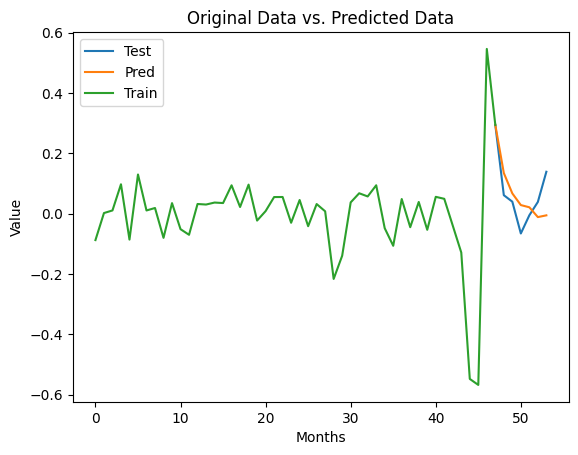

In [ ]:
# Plot
plt.plot(list(range(47,54)), np.insert(single_test.reshape(6,), 0, single[0,47,0]), label='Test')
plt.plot(list(range(47,54)), np.insert(single_pred.reshape(6,), 0, single[0,47,0]), label='Pred')
plt.plot(list(range(0,48)), single.reshape(48,), label='Train')


# Set plot labels and title
plt.xlabel('Months')
plt.ylabel('Value')
plt.title('Original Data vs. Predicted Data')

# Add legend
plt.legend()

# Display the plot
plt.show()

#Plot the predictions

In [ ]:
# Indexing data 
times_exploded = []
forecast_len = testY.shape[1]
idx_list = data.index.to_list()

for i in range(len(data.index) - forecast_len):
  times_exploded.append(pd.to_datetime(idx_list[i : i + forecast_len]))

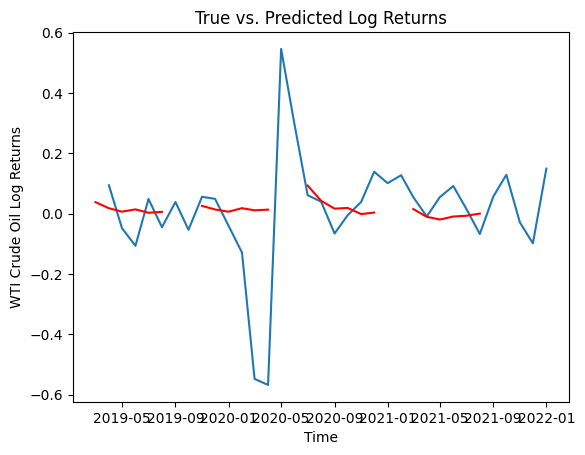

<Figure size 3200x500 with 0 Axes>

In [ ]:
# Plot the log returns

plt.plot(data.iloc[-len(y_pred):])

times = times_exploded[-len(y_pred):]
for idx in range(5, len(y_pred), 8):
  plt.plot(times[idx], y_pred[idx], color = 'r')

plt.xlabel("Time")
plt.ylabel("WTI Crude Oil Log Returns")
plt.title("True vs. Predicted Log Returns")
plt.figure(figsize = (32,5))

# Display the plot
plt.show()